 # The PyEl2d library for seismic modeling
 
 Pyel2d is a tiny library of python classes to perform simulation of elastic waves
 The code below demonstrates a simple example of simulating elastic waves.


## Animation of snapshots

In [7]:
'''  
Movie is a class displaying an animation of snapshots

'''

import matplotlib
#matplotlib.use('TKAgg')
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.animation as anim
import babin as ba
from matplotlib.pyplot import draw, ion
from math import *
from IPython.display import HTML
from IPython.display import display, Image


class movie :

  def updatefig(self,*args):
    ''' Callback function for updating each frame

    Arguments:
        *args: provided by callback

    Returns
        None
    '''
    
    im=self.im
    img = self.data[self.tstep,:,:] #Get the next frame
    im.set_array(img)               #Plot the frame 
    self.tstep =  self.tstep+1
    return(im,)


  def __init__(self,file,nx,ny,nt,dx):
    
    #Movie params
    self.im=0
    self.tstep=0
    self.nt=nt
    
    # Get the data from file
    fin=ba.bin(file)
    self.data=fin.read((nt,ny,nx))
        
    #Plot frame no 0
    fig = pl.figure()
    img = self.data[0,:,:]
    o1=0
    o2=0
    d1=dx
    d2=d1
    n1=nx
    n2=ny
    cmin=-1.0e-07
    cmax= 1.0e-07
    colormap="gray"
    self.im=pl.imshow(img,interpolation='nearest',clim=(cmin,cmax),
                 cmap=colormap,extent=[o1,o1+d1*n1,o2+d2*n2,o2],animated=True)
    #self.im=pl.imshow(img,interpolation='nearest',
     #       cmap=colormap,extent=[o1,o1+d1*n1,o2+d2*n2,o2],animated=True)
    ax=pl.gca()
    ar=1.0
    asr = 1.0/(ax.get_data_ratio()*ar)
    pl.Axes.set_aspect(ax,asr)
    #Animation loop
    ani = anim.FuncAnimation(fig, self.updatefig, frames=self.nt-4, repeat=True, interval=100, blit=True)
    #pl.close(ani.fig)
    display(HTML(ani.to_html5_video()))
    

# Modeling of elastic waves

Elastic 2d  cuda  version


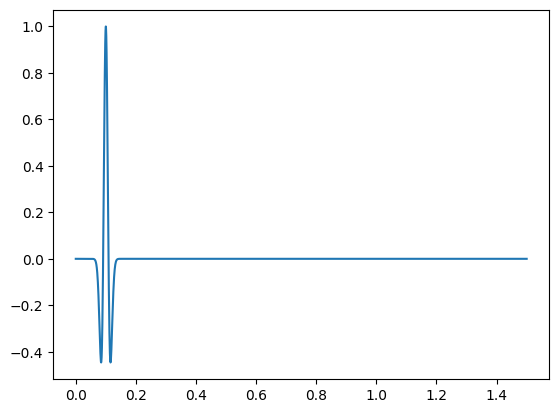

10
20
30
40
50
60
70
80
90
100


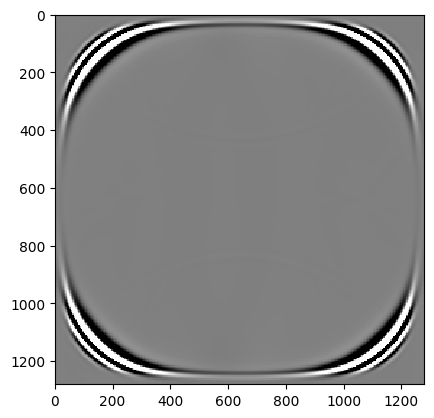

In [8]:
''' El2d performs modeling of elastic waves'''

import numpy as np
import matplotlib.pyplot as pl
import el2d
import src
import rec
import model


# Setup of library
path="/home/barn/Dropbox/Src/PyEl2d/Bin/"
#arch="c"        # Cpu
#arch="omp"      # Cpu multiprocessor
arch="cuda"      # Nvidia
      # Cpu multiprocessor

print("Elastic 2d ",arch," version")
lib = el2d.setup(path,arch)

# Set the size of the model
nx = 256          # Size in x-direction
ny = 256          # Size in y-direction
dx = 5.0          # Grid size

# Set the simulation time
nt = 3001         # No of time samples
dt = 0.0005        # Time sampling interval

# Set source position
sx = np.zeros(1)
sy = np.zeros(1)
sx[0] = nx/2      # x-coord (in gridpoints) of source
sy[0] = ny/2      # y-coord (in gridpoints) of source

# Set source time parameters (using the default ricker wavelet)
f0 = 25.0
t0 = 0.1

# Create a horizontal force
sfx = np.zeros((nt,1))
# Use a ricker as time function
sfx[:,0] = src.ricker(nt,f0,t0,dt)
# Create a source object
s = src.src(lib,sx,sy,nt,dt,f0,t0,sfx=sfx)

#Plot the source pulse
t=dt*(nt-1)
t=np.linspace(0,t,nt)
pl.figure()
pl.plot(t,src.ricker(nt,f0,t0,dt))  
pl.show()         
          
# Create receiver positions
rx = np.zeros(nx)
ry = np.zeros(ny)
for i in range(0,nx) :
  rx[i] = i
  ry[i] = 10

# Set resampling of data recorded at the receiver (relative to modeling time sampling)
# Create a receiver object
r = rec.rec(lib, rx,ry, nt)

# Create a simplistic model
vp = 2500*np.ones((nx,ny))
vs = 1100*np.ones((nx,ny))
rho = 1000*np.ones((nx,ny))

w0=2.0*3.14159*f0
m = model.model(lib,vp,vs,rho,dx,dt,w0)

# Set snapshot type
snptype=np.zeros(4)
snptype[2] = 1  # (Output vx)

# Set snapshot resampling
sresamp = 10

# Create solver
sol = el2d.el2d(lib,m,sresamp,snptype)

# Run the simulation

sol.solve(lib,m,s,r,nt)

# Run snap shot movie
nt=150
movie("snp-vx.bin",nx,ny,nt,dx)
